# Social Graph Analysis Group Project

### Grandma’s Cookbook, Lookbook: An Analysis of Ingredients Association With Ethnic Cuisines

#### Group Members:
* Nick Potts
* Kristi Conry
* Jacob Lebowitz
* Anthony Bryson

### Possible Goals :)

1) Predict popular cuisine's based on what ingediants you have <br>
2) Essential ingrediants if you like a favorite cuisine <br>
3) Ingrediant recommendation system ( if you lke 3 types of cuisine find top similar ingrediants ) 

### Just some questions for our data :)

1) Which cuisine's are most similar based on ingediants? and why?

In [87]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import json
import collections
import re
import pickle
import statistics

from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [92]:
df = pd.read_csv('data/cleaned_data.csv', converters={'ingredient_list_cleaned': lambda x: x[1:-1].replace("'", '').split(','),
                                                      'ingredients': lambda x: x[1:-1].replace("'", '').split(',')})

In [ ]:
df.head()

In [93]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [ ]:
real_ingredients = []

for ingredients in df['ingredient_list_cleaned']:
    for ingredient in ingredients:
        real_ingredients.append(ingredient.strip())
        
count_of_ingredient = collections.Counter(real_ingredients)
count_of_ingredient.most_common(10)


In [ ]:
len(count_of_ingredient.keys())

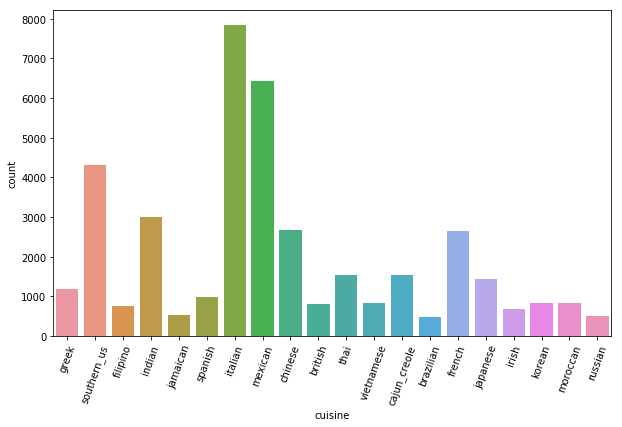

In [94]:
fig = plt.figure(figsize=[10,6])
plt.xticks(rotation=70)
sns.countplot(df['cuisine'])

In [ ]:
count_of_ingredient_ordered = sorted(count_of_ingredient.items(), key=lambda x: x[1], reverse=True)

In [ ]:
count_of_ingredient.most_common(10)

ingredients = []
counter = []

for counted_ingredients in count_of_ingredient.most_common(40):
    ingredients.append(counted_ingredients[0])
    counter.append(counted_ingredients[1])
    
fig = plt.figure(figsize=[16,8])

plt.xticks(rotation=70)

sns.barplot(x=ingredients, y=counter)

In [ ]:
sentences = []

for ingredients in df['ingredient_list_cleaned']:
    cleaned_ing = []
    for ingredient in ingredients:
        ingredient = re.sub('r\(.*oz\)|minced|poweder|chopped|sliced|paste|crushed|ground|diced', '', ingredient)
        cleaned_ing.append(ingredient.strip())
    sentences.append(cleaned_ing)
    
print(len(sentences))
print(sentences[:10])

In [ ]:
keys = count_of_ingredient.keys()
values = count_of_ingredient.values()

fig1, ax1 = plt.subplots()
ax1.set_title('Number of Ingredients')
ax1.boxplot(list(values), showfliers=False)

len_of_sentences = df['ingredient_list_cleaned'].apply(lambda x: len(x))
print(type(len_of_sentences))
print(len_of_sentences.describe())

fig2, ax2 = plt.subplots()
ax2.set_title('Length of Sentences')
ax2.boxplot(len_of_sentences, showfliers=False)

In [ ]:
num_of_features = 250 # Dimensionality of the word vectors.

min_word_count = 4 # Ignores all words with total frequency lower than this.

num_workers = 4 # Use these many worker threads to train the model

window_context = 6 # Maximum distance between the current and predicted word within a sentence.

sample = 1e-3 # The threshold for configuring which higher-frequency words are randomly downsampled.

In [ ]:
model = word2vec.Word2Vec(sentences, size=num_of_features,
                          min_count=min_word_count, workers=num_workers,
                          window=window_context, sample=sample)

In [ ]:
model.wv.most_similar('jalapeno chili')

In [ ]:
model.wv.similarity('fresh pineappl', 'milk')

In [ ]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,250), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.similar_by_word(word)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

In [19]:
model.wv.most_similar('romain lettuc')

[('orang bell pepper', 0.9075711369514465),
 ('cherri tomato', 0.8766277432441711),
 ('avocado', 0.8739045858383179),
 ('yellow bell pepper', 0.8732463121414185),
 ('grape tomato', 0.8645813465118408),
 ('roma tomato', 0.8590236902236938),
 ('reducedfat sour cream', 0.8582755327224731),
 ('bake tortilla chip', 0.854686439037323),
 ('reduc sodium black bean', 0.8538311123847961),
 ('jicama', 0.8485833406448364)]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  import sys
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


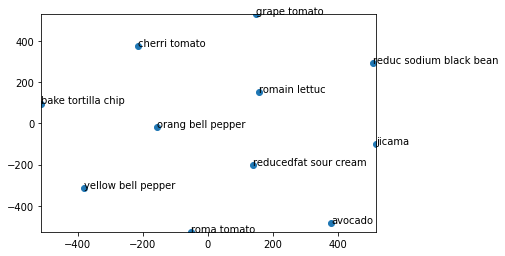

In [20]:
display_closestwords_tsnescatterplot(model, 'romain lettuc')

In [ ]:
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
        
    #print(tokens[:5])
    #print(labels[:5])
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    '''
    tool to visualize high-dimensional data. It converts similarities between data points to joint
    probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities 
    of the low-dimensional embedding and the high-dimensional data
    '''
    new_values = tsne_model.fit_transform(tokens)
    #print(new_values)
    #print(new_values[:5])
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    #print(x[0])
    #print(y[0])
    '''
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        #plt.annotate('',
         #            xy=(x[i], y[i]),
          #           xytext=(5, 2),
           #          textcoords='offset points',
            #         ha='right',
             #        va='bottom')
    plt.show()
    '''

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

In [ ]:
model.wv.most_similar('romain lettuc')

In [ ]:
# 1) User Search for Ingredient that they enjoy --> Once Found reeccomend ingredients

In [ ]:
from gensim.models import Word2Vec, KeyedVectors   
model.wv.save_word2vec_format('model.bin', binary=True)

In [ ]:
model.save("model.model")

In [34]:
ingred = []
for key, value in count_of_ingredient.items():
    if value > 4:
        if key != '':
            if key[0] == ' ':
                key = key[1:]
            ingred.append(key)

In [35]:
len(ingred)

3328

In [10]:
cuisineObj = []
for key, value in cuisine_counter.items():
    cuisineObj.append(key)
    
#print(len(cuisineObj))

In [36]:
import pickle

In [37]:
with open('ingred_list_v2.pkl', 'wb') as f:
    pickle.dump(ingred, f)
    
    
with open('cuisine_obj.pkl', 'wb') as f:
    pickle.dump(cuisineObj, f)

In [13]:
cuisineObj

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']

In [14]:
df['cuisine']

0              [greek]
1        [southern_us]
2           [filipino]
3             [indian]
4             [indian]
             ...      
39769          [irish]
39770        [italian]
39771          [irish]
39772        [chinese]
39773        [mexican]
Name: cuisine, Length: 39774, dtype: object

In [15]:
dict = {}

# iterate over each row
    # iterate over ingredient list cleaned
        if ingred is not in dict
            add key to dict withvalue in list
        else
            append cusine to value lsit at dict[key]
            

IndentationError: unexpected indent (<ipython-input-15-5464665df482>, line 5)

In [16]:
df['cuisine'] = df['cuisine'].apply(lambda x: x[0])

In [ ]:
df.head()

In [ ]:
cook_book = {}

for index, row in df.iterrows():
    
    #print(row['cuisine'], row['ingredient_list_cleaned'])

    #print(row['cuisine'])
    for ingred in row['ingredient_list_cleaned']:
        if ingred[0] == ' ':
            ingred = ingred[1:]
        #print(row['cuisine'])
        if ingred not in cook_book.keys():
            #print(ingred)
            cook_book[ingred] = dict()
            cook_book[ingred][row['cuisine']] = 1
            
        else:
            if row['cuisine'] in cook_book[ingred].keys():
                cook_book[ingred][row['cuisine']] += 1
            else:
                cook_book[ingred][row['cuisine']] = 1
                
        cook_book[ingred] = dict(sorted(cook_book[ingred].items(), key=lambda kv: kv[1], reverse=True))
        
            #cook_book[ingred][row['cuisine']] += 1
            
        
            
    
    

In [ ]:
with open('cook_book_v3.pkl', 'wb') as f:
    pickle.dump(cook_book, f)
    

In [ ]:
cook_book['grill chicken breast']

In [ ]:
cook_book